# PETH Tutorial

## Import Required Libraries
This tutorial shows how to compute peri-event time histograms (PETHs) for multiple data types using `peth` and how to visualize the results with a real session.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel

from neuro_py.io import loading
from neuro_py.process.peri_event import peth
import neuro_py as npy

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (8, 4)

## Load Sample Neural Data
We load real data from a single session and reuse the same event timestamps across examples.

Session basepath: `S:\data\HMC\HMC1\day8`

In [ ]:
basepath = r"S:\data\HMC\HMC1\day8"

ripple_channel = 261
sharp_wave_channel = 282
delta_channel = 53

# Load spikes and restrict to two units for clean plots
st, cell_metrics = npy.io.load_spikes(
    basepath, brainRegion="CA1|PFC", putativeCellType="Pyr"
)

ca1_idx = cell_metrics.brainRegion.str.contains("CA1").values
pfc_idx = cell_metrics.brainRegion.str.contains("PFC").values

# Load ripple events as the alignment events
ripples = npy.io.load_ripples_events(basepath, return_epoch_array=True)
ripples_df = npy.io.load_ripples_events(basepath, return_epoch_array=False)

deltas = npy.io.load_events(basepath, epoch_name="deltaWaves", load_pandas=True)

# load sleep states
sleep_states = npy.io.load_SleepState_states(basepath, return_epoch_array=True)

# Load continuous signals
# lfp = npy.io.LFPLoader(basepath)

nChannels, fs, fs_dat, shank_to_channel = loading.loadXML(basepath)
lfp, ts = loading.loadLFP(basepath, n_channels=nChannels, frequency=fs, ext="lfp")


## Define PETH Parameters
We use a symmetric window around each event and a consistent bin width.

In [3]:
window = [-1, 1]
bin_width = 0.01

## Calculate PETH for Spike Data
We compute PETHs for spike-like data structures: `SpikeTrainArray`, `EventArray`, numpy object arrays, and numpy 1D arrays.

Text(0.5, 1.0, 'PFC Pyr cells')

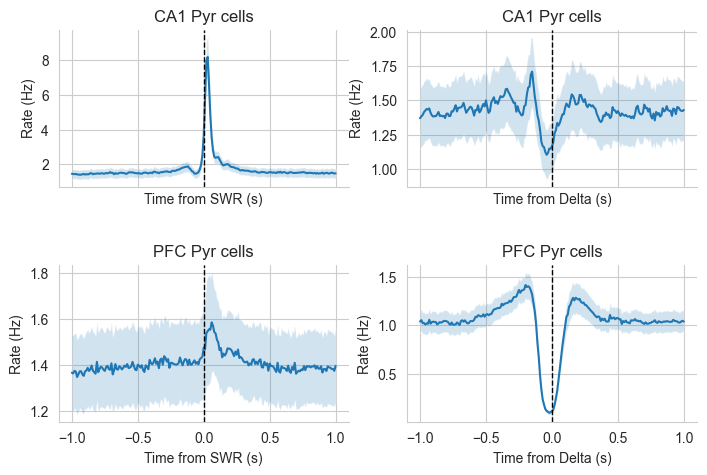

In [4]:
peth_st_swr_ca1 = peth(
    st.iloc[:, ca1_idx], ripples.starts, bin_width=bin_width, window=window
)
peth_st_delta_ca1 = peth(
    st.iloc[:, ca1_idx], deltas.peaks.values, bin_width=bin_width, window=window
)

peth_st_swr_pfc = peth(
    st.iloc[:, pfc_idx], ripples.starts, bin_width=bin_width, window=window
)
peth_st_delta_pfc = peth(
    st.iloc[:, pfc_idx], deltas.peaks.values, bin_width=bin_width, window=window
)

fig, axes = plt.subplots(
    2,
    2,
    figsize=npy.plotting.set_size("paper", 1, subplots=(2, 2)),
    sharex=True,
    dpi=100,
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
npy.plotting.plot_peth_fast(peth_st_swr_ca1, ax=axes[0, 0])
npy.plotting.plot_peth_fast(peth_st_delta_ca1, ax=axes[0, 1])
npy.plotting.plot_peth_fast(peth_st_swr_pfc, ax=axes[1, 0])
npy.plotting.plot_peth_fast(peth_st_delta_pfc, ax=axes[1, 1])

for ax in axes.ravel():
    ax.axvline(0, color="k", ls="--", lw=1)
    # ax.set_title(title)
    ax.set_xlabel("Time from event (s)")
    ax.set_ylabel("Rate (Hz)")

axes[0, 0].set_xlabel("Time from SWR (s)")
axes[0, 1].set_xlabel("Time from Delta (s)")
axes[1, 0].set_xlabel("Time from SWR (s)")
axes[1, 1].set_xlabel("Time from Delta (s)")

axes[0, 0].set_title("CA1 Pyr cells")
axes[0, 1].set_title("CA1 Pyr cells")
axes[1, 0].set_title("PFC Pyr cells")
axes[1, 1].set_title("PFC Pyr cells")


## Calculate PETH for Continuous Data
For continuous signals (e.g., LFP or position), `peth` computes event-triggered averages.

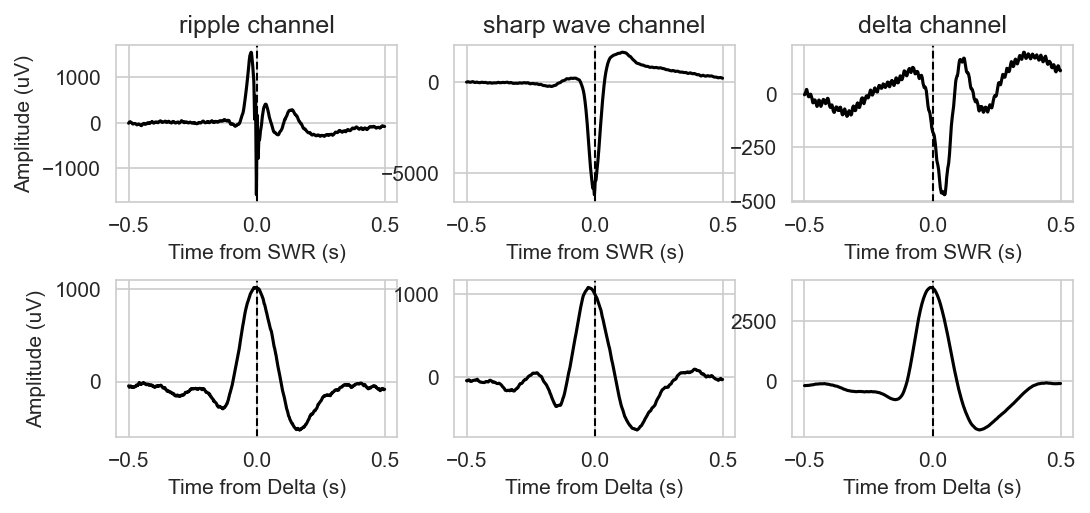

In [ ]:
lfp_idx = npy.process.in_intervals(ts, sleep_states["NREMstate"].data)
lfp = nel.AnalogSignalArray(
    data=lfp[lfp_idx, :][:, [ripple_channel, sharp_wave_channel, delta_channel]].T,
    abscissa_vals=ts[lfp_idx],
)


peth_lfp_swr = peth(
    lfp, ripples_df.peaks.values, bin_width=1 / 1250, window=[-0.5, 0.5]
)
peth_lfp_delta = peth(lfp, deltas.peaks.values, bin_width=1 / 1250, window=[-0.5, 0.5])

fig, axes = plt.subplots(
    2, 3, figsize=npy.plotting.set_size("paper", 1, subplots=(2, 3)), dpi=150
)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axes = axes.ravel()
peth_lfp_swr.iloc[:, 0].plot(ax=axes[0], color="k", label="Ripple channel")
peth_lfp_swr.iloc[:, 1].plot(ax=axes[1], color="k", label="Sharp wave channel")
peth_lfp_swr.iloc[:, 2].plot(ax=axes[2], color="k", label="Delta channel")


peth_lfp_delta.iloc[:, 0].plot(ax=axes[3], color="k", label="Ripple channel")
peth_lfp_delta.iloc[:, 1].plot(ax=axes[4], color="k", label="Sharp wave channel")
peth_lfp_delta.iloc[:, 2].plot(ax=axes[5], color="k", label="Delta channel")


axes[0].set_title("ripple channel")
axes[1].set_title("sharp wave channel")
axes[2].set_title("delta channel")

axes[0].set_xlabel("Time from SWR (s)")
axes[1].set_xlabel("Time from SWR (s)")
axes[2].set_xlabel("Time from SWR (s)")

axes[3].set_xlabel("Time from Delta (s)")
axes[4].set_xlabel("Time from Delta (s)")
axes[5].set_xlabel("Time from Delta (s)")

axes[0].set_ylabel("Amplitude (uV)")
axes[3].set_ylabel("Amplitude (uV)")

for ax_ in axes:
    ax_.axvline(0, color="k", ls="--", lw=1)
